# Generating SBM-Environment Dataset

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sbm_environment import generate_sbm_graph_list

In [2]:
sbmg = generate_sbm_graph_list(n_samples=1)[0]
graph_data, domain_id = sbmg.get()
# just for pretty print
graph_data['x'] = graph_data['x'].T
print(graph_data)
print(domain_id)
print(sbmg.stat())

Total generation time: 0.79 secs.                 
{'x': tensor([[0, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 1, 2,
         1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2,
         0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2,
         1, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0]]), 'y': tensor(7), 'edge_index': tensor([[ 0,  0,  0,  ..., 89, 89, 89],
        [ 3,  4,  6,  ..., 80, 83, 88]])}
14
{'# of nodes': 90, '# of edges': 1386, 'avg degree': 15.4}


In [3]:
sbm_graph_list = generate_sbm_graph_list(n_samples=10000, n_processes=8)

Total generation time: 54.20 secs.                


Labels: min: 0, max: 9


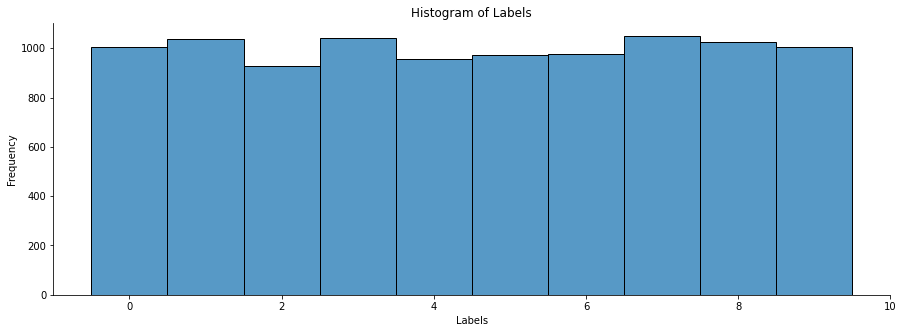

Doamin Ids: min: 0, max: 14


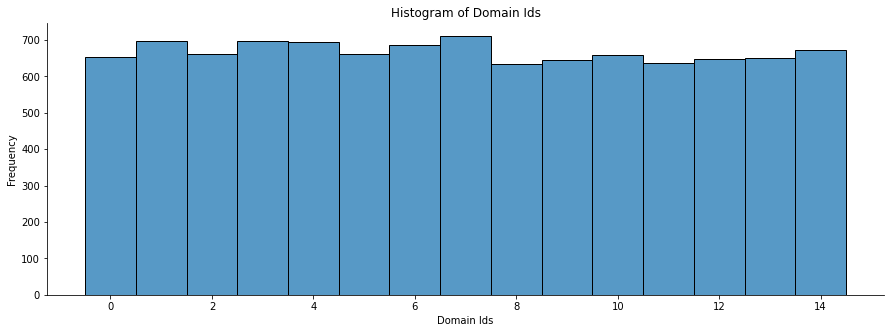

Graph sizes: min: 41, max: 93


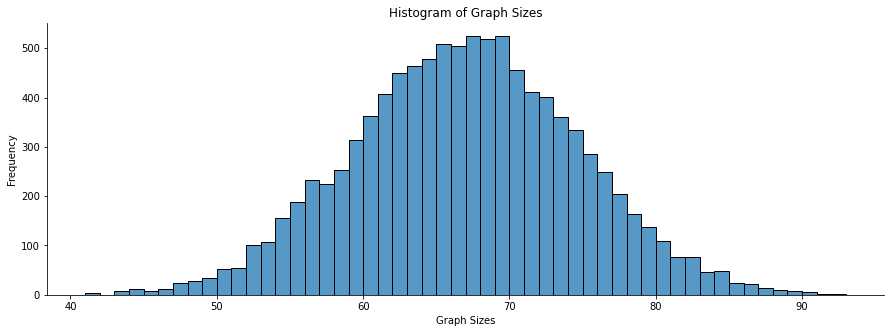

In [4]:
label_list = [int(sbmg.get()[0]['y']) for sbmg in sbm_graph_list]
domain_id_list = [int(sbmg.get()[1]) for sbmg in sbm_graph_list]
graph_size_list = [int(sbmg.stat()['# of nodes']) for sbmg in sbm_graph_list]


print(f'Labels: min: {min(label_list)}, max: {max(label_list)}')
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(label_list, binwidth=1, binrange=(-0.5, 9.5))
ax.set_xlabel('Labels')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Labels')
plt.show()

print(f'Doamin Ids: min: {min(domain_id_list)}, max: {max(domain_id_list)}')
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(domain_id_list, binwidth=1, binrange=(-0.5, 14.5))
ax.set_xlabel('Domain Ids')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Domain Ids')
plt.show()

print(f'Graph sizes: min: {min(graph_size_list)}, max: {max(graph_size_list)}')
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(graph_size_list, binwidth=1)
ax.set_xlabel('Graph Sizes')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Graph Sizes')
plt.show()

In [5]:
torch.save([sbmg.get()[0] for sbmg in sbm_graph_list], 'SBM-Environment.pt')
np.save('SBM-Environment_group.npy', np.array([sbmg.get()[1] for sbmg in sbm_graph_list]))